In [ ]:
## IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import copy
from gensim.models import Word2Vec
import spacy
sp = spacy.load("en_core_web_sm")
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize
from spacy import tokenizer
#nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from google.colab import drive
stop_words = set(stopwords.words('english'))  
drive.mount('/content/drive/')
PATH = '/content/drive/My Drive/Colab/HW3/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**PROBLEM 2**

In [ ]:
## PREPROCESSING
def preprocessing(raw_data, include_stopwords = True):
    ## Tokenize tweet wise, extract only words, and lower case
    tokenizer = RegexpTokenizer(r'[A-Za-z]+')
    raw_data = raw_data.str.lower()
    if include_stopwords:
        tok_data = [tokenizer.tokenize(el) for el in raw_data]
    else:
        tok_data = [tokenizer.tokenize(el) for el in raw_data]
        tok_data = [[el for el in tweet if not el in stop_words] for tweet in tok_data] 
    return tok_data

## Count Vectorized
def count_vect_fit(raw_data, max_features = 1000):
    c_v = CountVectorizer(stop_words='english', max_features=max_features)
    features = c_v.fit_transform(raw_data)
    cv_model = c_v.transform
    return cv_model, features

## TFIDF Vectorized
def t_vect_fit(raw_data, max_features = 1000):
    t_v= TfidfVectorizer(stop_words='english', max_features=max_features)
    features = t_v.fit_transform(raw_data)
    tv_model = t_v.transform
    return tv_model, features

## Word2Vec
def word_vec(raw_data, size = 300, min_count=5):
    model_w2v = Word2Vec(raw_data, size=size, min_count=min_count) # as input it takes the list of list of words in each tweet
    #print(model_w2v)
    voc = list(model_w2v.wv.vocab)
    features = model_w2v.wv
    return features, voc
def word_vector(features_extractor, tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += features_extractor[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec
def avg_vect(features_extractor, tweet_list, size):
    features_train_avg = np.zeros((len(tweet_list), size)) 
    for i in range(len(tweet_list)):
        features_train_avg[i,:] = word_vector(features_extractor, tweet_list[i], size)   
    return features_train_avg

In [ ]:
## MODELS
## Multi Naive Bayes
def multi_nb_fit(features, labels):
    model = MultinomialNB()
    model = model.fit(features, labels) #mnb.fit(twitter_data_tf, twitter_data.sentiment)
    return model

## Logistic Regression
def log_reg_fit(features, labels):
    model = LogisticRegression(max_iter=500)
    model = model.fit(features, labels) #lr.fit(twitter_data_tf,twitter_data.sentiment)
    #y_pred_train = lr.predict(twitter_data_tf)
    #confusion_matrix(y_true=twitter_data.sentiment, y_pred=y_pred_train)
    return model


def test_model(model, test_data, labels, cm=False):
    pred = model.predict(test_data)
    confusion_matrix(y_true=labels, y_pred=pred) #confusion_matrix(y_true=twitter_data.sentiment, y_pred=y_pred_train)
    if cm:
        cm = plot_confusion_matrix(model, test_data, labels) #plot_confusion_matrix(mnb, twitter_data_tf, twitter_data.sentiment)
        plt.grid(False)
    accuracy = accuracy_score(y_true=labels, y_pred=pred) #accuracy_score(y_true=twitter_data.sentiment, y_pred=y_pred_train)
    print("Accuracy: " + str(accuracy))
    return accuracy

## K-fold
def k_fold(data, labels):
    X_train, Y_train, X_test, Y_test = [], [], [], []
    skf = StratifiedKFold(n_splits=5)
    skf.get_n_splits(data, labels) # Returns number of splits
    skf.split(data, labels)
    for train_index, test_index in skf.split(data, labels):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train.append(data[train_index])
        X_test.append(data[test_index])
        Y_train.append(labels[train_index])
        Y_test.append(labels[test_index])
    return X_train, Y_train, X_test, Y_test

In [ ]:
## LOAD DATA
data_train = pd.read_csv(PATH+'sentiment-train.csv')
data_test = pd.read_csv(PATH+'sentiment-test.csv')
data_train = data_train[['sentiment','text']]
data_test = data_test[['sentiment','text']]
'''twitter_data.info()
twitter_data.sentiment.value_counts()
print(data_test.head())
print(data_test.text)
print(data_test.sentiment)'''


'twitter_data.info()\ntwitter_data.sentiment.value_counts()\nprint(data_test.head())\nprint(data_test.text)\nprint(data_test.sentiment)'

In [ ]:
## Question 1
cv_model, features_train = count_vect_fit(data_train.text, max_features = 1000)
features_test = cv_model(data_test.text)
model = multi_nb_fit(features_train, data_train.sentiment)
_ = test_model(model, features_test, data_test.sentiment)

Accuracy: 0.7827298050139275


In [ ]:
## Question 2
tv_model, features_train = t_vect_fit(data_train.text, max_features = 1000)
features_test = tv_model(data_test.text)
model = multi_nb_fit(features_train, data_train.sentiment)
_ = test_model(model, features_test, data_test.sentiment)

Accuracy: 0.7688022284122563


In [ ]:
## Question 3
cv_model, features_train = count_vect_fit(data_train.text, max_features = 1000)
features_test = cv_model(data_test.text)
model = log_reg_fit(features_train, data_train.sentiment)
_ = test_model(model, features_test, data_test.sentiment)

Accuracy: 0.766016713091922


In [ ]:
## Question 4
tv_model, features_train = t_vect_fit(data_train.text, max_features = 1000)
features_test = tv_model(data_test.text)
model = log_reg_fit(features_train, data_train.sentiment)
_ = test_model(model, features_test, data_test.sentiment)

Accuracy: 0.7688022284122563


In [ ]:
## Question 5
X_train, Y_train, X_test, Y_test = k_fold(data_train.text, data_train.sentiment)
max_features_list = [1000, 2000, 3000, 4000]
avg_acc = []
for max_features in max_features_list:
    print(" ----- Max_features {}".format(max_features))
    acc = 0
    for i, (x_train, y_train, x_test, y_test) in enumerate(zip(X_train, Y_train, X_test, Y_test)): 
        #print("Fold {}".format(i))
        tv_model, features_train = t_vect_fit(x_train, max_features = max_features)
        features_test = tv_model(x_test)
        model = multi_nb_fit(features_train, y_train) 
        acc += test_model(model, features_test, y_test)
    avg = acc/5
    print("Average accuracy: {}".format(avg))
    avg_acc.append(acc/5)
max_value = max(avg_acc)
max_index = avg_acc.index(max_value)
print("\n --- Average accuracy {}\n --- Max accuracy {} with max_features = {}".format(sum(avg_acc)/len(avg_acc), max_value, max_features_list[max_index]))
print("\n --- With optimal setting found")
tv_model, features_train = t_vect_fit(data_train.text, max_features = max_features_list[max_index])
features_test = tv_model(data_test.text)
model = multi_nb_fit(features_train, data_train.sentiment) 
_ = test_model(model, features_test, data_test.sentiment)

 ----- Max_features 1000
Accuracy: 0.7089166666666666
Accuracy: 0.7101666666666666
Accuracy: 0.7171666666666666
Accuracy: 0.72175
Accuracy: 0.72375
Average accuracy: 0.71635
 ----- Max_features 2000
Accuracy: 0.72225
Accuracy: 0.7215
Accuracy: 0.72275
Accuracy: 0.7299166666666667
Accuracy: 0.7339166666666667
Average accuracy: 0.7260666666666666
 ----- Max_features 3000
Accuracy: 0.7273333333333334
Accuracy: 0.7254166666666667
Accuracy: 0.72775
Accuracy: 0.7320833333333333
Accuracy: 0.7340833333333333
Average accuracy: 0.7293333333333333
 ----- Max_features 4000
Accuracy: 0.7278333333333333
Accuracy: 0.726
Accuracy: 0.7296666666666667
Accuracy: 0.73475
Accuracy: 0.7350833333333333
Average accuracy: 0.7306666666666667

 --- Average accuracy 0.7256041666666666
 --- Max accuracy 0.7306666666666667 with max_features = 4000

 --- With optimal setting found
Accuracy: 0.7715877437325905


In [ ]:
## Question 6
## Train
tweet_list = preprocessing(data_train.text)
features_extractor, _ = word_vec(tweet_list)
features_train_avg = avg_vect(features_extractor, tweet_list, 300)
## Test
tweet_list = preprocessing(data_test.text)
features_test_avg = avg_vect(features_extractor, tweet_list, 300)
## Logistic reg
model = log_reg_fit(features_train_avg, data_train.sentiment)
_ = test_model(model, features_test_avg, data_test.sentiment)

## Remove stop word and retrain
tweet_list = preprocessing(data_train.text, include_stopwords=False)
features_extractor, _ = word_vec(tweet_list)
features_train_avg = avg_vect(features_extractor, tweet_list, 300)
## Test
tweet_list = preprocessing(data_test.text)
features_test_avg = avg_vect(features_extractor, tweet_list, 300)
## Logistic reg
model = log_reg_fit(features_train_avg, data_train.sentiment)
_ = test_model(model, features_test_avg, data_test.sentiment)

#tweet_w2v.most_similar('good')

Accuracy: 0.6545961002785515
Accuracy: 0.6685236768802229


In [ ]:
## BONUS
with open(PATH+'complete_data/train.csv') as csvfile:
    data_train = pd.read_csv(csvfile, header=None)
print(data_train.head())
with open(PATH+'complete_data/test.csv') as csvfile:
    data_test = pd.read_csv(csvfile, header=None)
print(data_test.head())
train = data_train[5]
train_label = data_train[0]
test = data_test[5]
test_label = data_test[0]
print(len(train))
print(len(test))
cv_model, features_train = count_vect_fit(train, max_features = 1000)
features_test = cv_model(test)
model = multi_nb_fit(features_train, train_label)
_ = test_model(model, features_test, test_label)

UnicodeDecodeError: ignored

**PROBLEM 3**

In [ ]:
def count_vect_fit(voc, raw_data):
    vectorizer = CountVectorizer(stop_words='english')
    voc_features = vectorizer.fit_transform(voc)
    features = vectorizer.transform(raw_data)
    return voc_features, features.toarray(), vectorizer
def t_vect_fit(voc, raw_data):
    vectorizer = TfidfVectorizer(stop_words='english')
    voc_features = vectorizer.fit_transform(voc)
    features = vectorizer.transform(raw_data)
    return voc_features, features.toarray(), vectorizer

def word_vec(raw_data, size = 300, min_count=5):
    model_w2v = Word2Vec(raw_data, size=size, min_count=min_count) # as input it takes the list of list of words in each tweet
    voc = list(model_w2v.wv.vocab)
    features = model_w2v.wv
    return features, voc
def w2vec_extract(model, sentences):
    v = []
    for i, sent in enumerate(sentences):
        x = []
        for word in sent:
            if word in model.wv.vocab: 
                x.append(model[word].reshape((len(model[word]),1)))
        if not x:
            continue
        else:
            v.append(np.squeeze(np.array(x).mean(0)))
    return np.array(v)
    
## Word word matrix
def w_w_matrix(df, vectorizer):
    X = vectorizer.transform(df[2])
    Xc = (X.T * X)
    Xc.setdiag(0)
    return Xc.todense()
    
def pca(matrix, name_list):
    pca = PCA(n_components=2)
    plt.figure(figsize=(15,15))
    pca_proj = pca.fit_transform(matrix)
    plt.scatter(pca_proj[:, 0], pca_proj[:, 1])
    for i, name in enumerate(name_list):
        plt.annotate(name, xy=(pca_proj[i, 0], pca_proj[i, 1]))

## Compute cosine similiarity for each genre matrix
def cosine_sim(A):
    from sklearn.metrics.pairwise import cosine_similarity
    from scipy import sparse
    #A =  np.array([[0, 1, 0, 0, 1],[0, 0, 1, 1, 1],[1, 1, 0, 1, 0]])
    A_sparse = sparse.csr_matrix(A)
    similarities = cosine_similarity(A_sparse)
    #print('pairwise dense output:\n {}\n'.format(similarities))
    print('Cosine similarity mean:\n {}\n'.format(np.mean(similarities)))
    
trag = ['Troilus and Cressida','Coriolanus','Titus Andronicus','Romeo and Juliet','Timon of Athens','Julius Caesar','macbeth','Hamlet','King Lear','Othello','Antony and Cleopatra','Cymbeline']
hist = ['King John','Richard II','Henry IV','Henry V','Henry VI Part 1','Henry VI Part 2','Henry VI Part 3','Henry VIII','Richard III']
com = ['Alls well that ends well','Loves Labours Lost','Taming of the Shrew','A Midsummer nights dream','Merry Wives of Windsor','A Winters Tale','The Tempest','As you like it','A Comedy of Errors','Measure for measure','Two Gentlemen of Verona','Much Ado about nothing','Twelfth Night','Merchant of Venice','Pericles']

In [ ]:
## LOAD DATA
df = pd.read_csv(PATH+'will_play_text.csv', usecols=[1,4,5], sep=';', header=None)
with open(PATH+'play_names.txt') as f:
    plays = f.readlines()
plays = [x.strip() for x in plays] 
with open(PATH+'vocab.txt') as f:
    vocab = f.readlines()
vocab = [x.strip() for x in vocab] 
df.iloc[:,2]= df.iloc[:,2].str.lower()
chars = df[4]
chars = [str(el) for el in chars if str(el) != 'nan']
chars = list(dict.fromkeys(chars))
print(df.head())
print(chars)
print(plays[0:100])
print(vocab[0:100])

          1              4                                                  5
0  Henry IV            NaN                                              act i
1  Henry IV            NaN                       scene i. london. the palace.
2  Henry IV            NaN  enter king henry, lord john of lancaster, the ...
3  Henry IV  KING HENRY IV             so shaken as we are, so wan with care,
4  Henry IV  KING HENRY IV         find we a time for frighted peace to pant,
['KING HENRY IV', 'WESTMORELAND', 'FALSTAFF', 'PRINCE HENRY', 'POINS', 'EARL OF WORCESTER', 'NORTHUMBERLAND', 'HOTSPUR', 'SIR WALTER BLUNT', 'First Carrier', 'Ostler', 'Second Carrier', 'GADSHILL', 'Chamberlain', 'BARDOLPH', 'PETO', 'First Traveller', 'Thieves', 'Travellers', 'LADY PERCY', 'Servant', 'FRANCIS', 'Vintner', 'Hostess', 'Sheriff', 'Carrier', 'MORTIMER', 'GLENDOWER', 'EARL OF DOUGLAS', 'Messenger', 'VERNON', 'WORCESTER', 'ARCHBISHOP OF YORK', 'SIR MICHAEL', 'LANCASTER', 'BEDFORD', 'GLOUCESTER', 'EXETER', 'OF WINCHE

In [ ]:
## Question 1
## plays
df[2] = df.iloc[:,2].apply(lambda x: str(sp.tokenizer(x.lower())))
df_plays = df.groupby([1])[2].apply(lambda x : ' '.join(x))
plays_tokens = df_plays.drop_duplicates().reindex(plays).reset_index().iloc[:,1]

print(len(plays_tokens))
print(len(chars_tokens))
cv_vector_words, cv_vector_plays, vectorizer = count_vect_fit(vocab, plays_tokens)

36
934


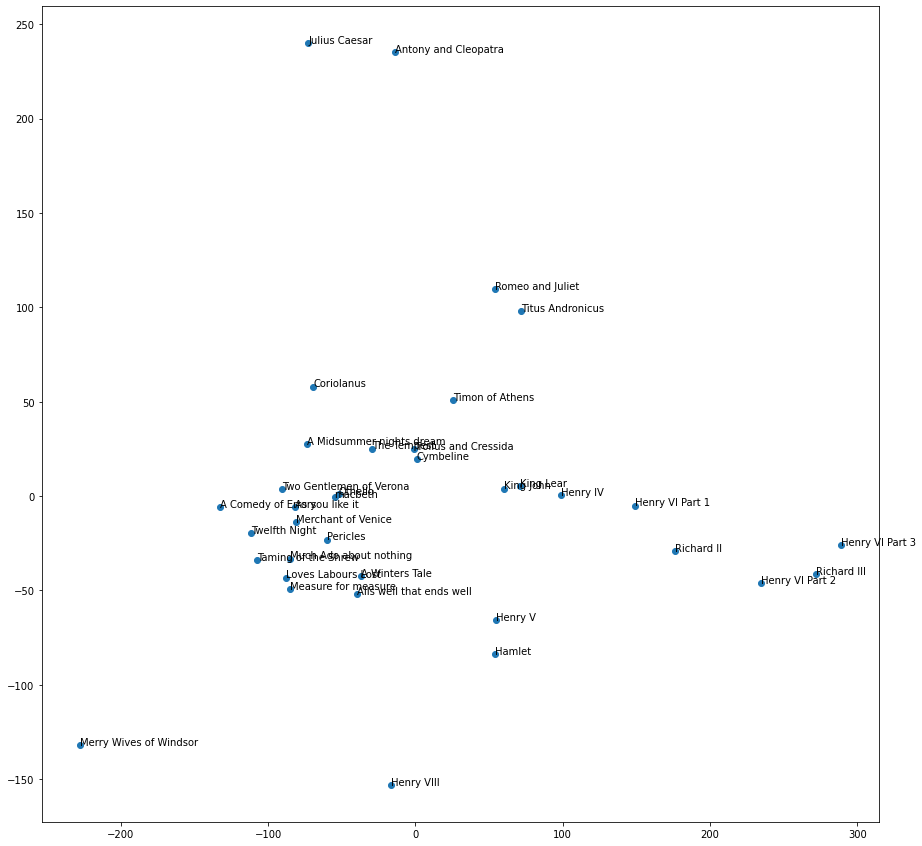

In [ ]:
## Question 2
pca(cv_vector_plays, plays)

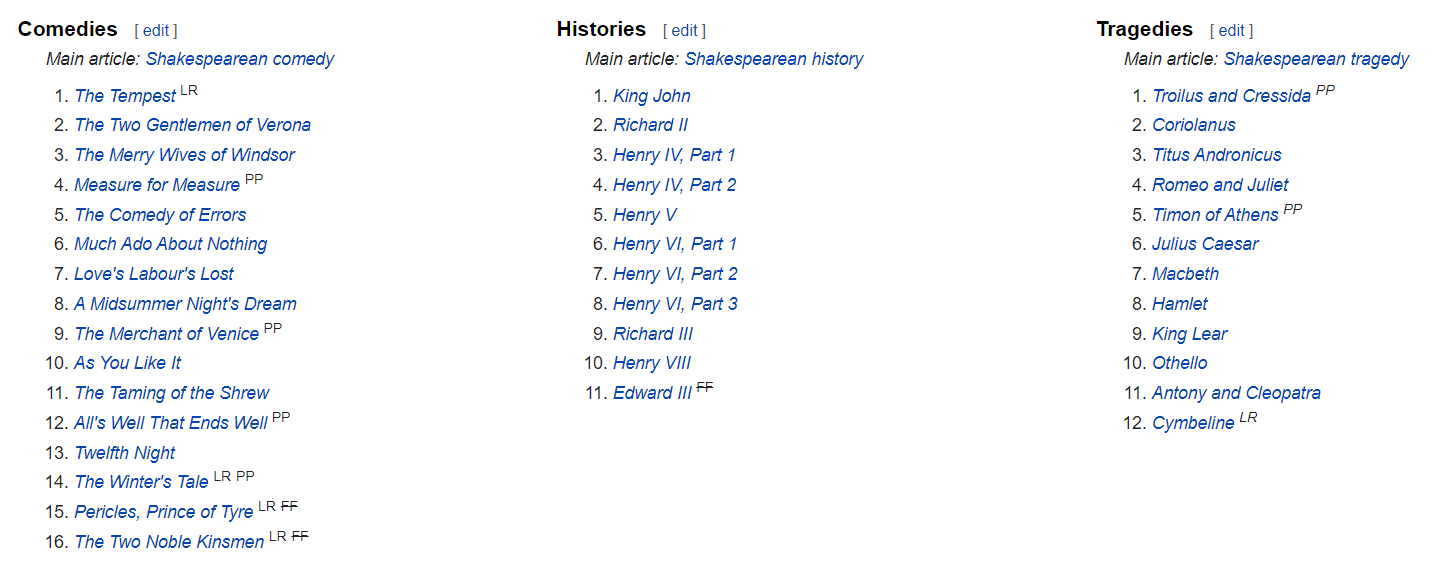

In [ ]:
## Question 3
t_vector_words, t_vector_plays, _ = t_vect_fit(vocab, plays_tokens)

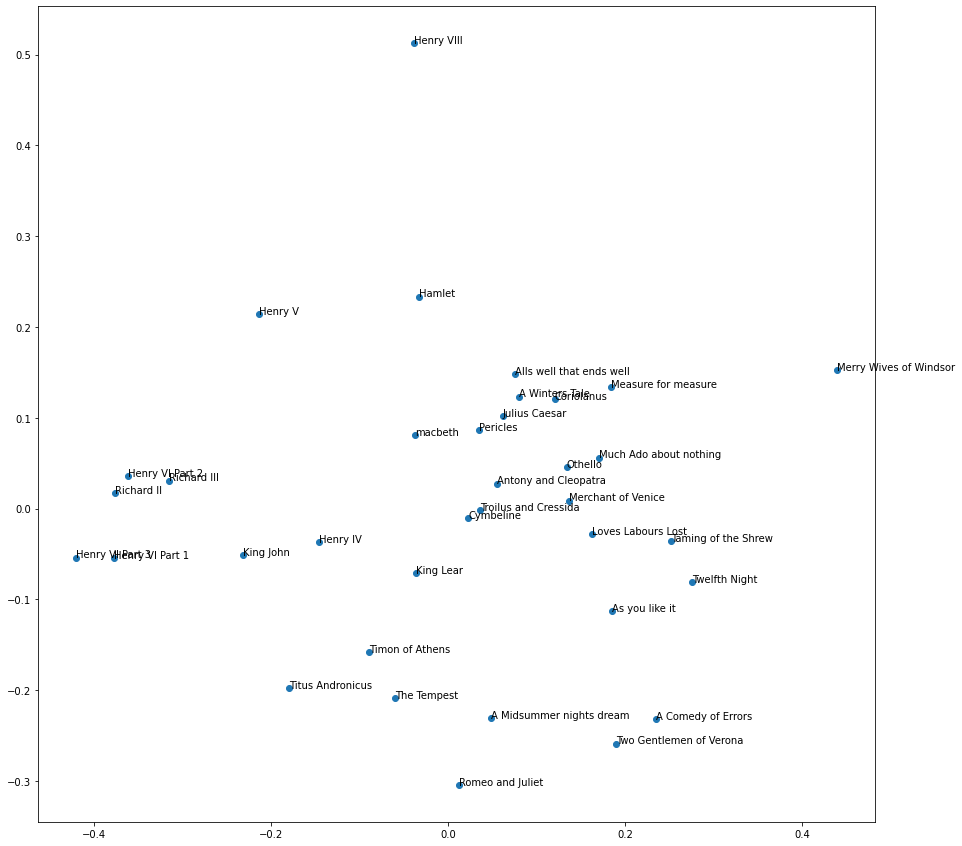

In [ ]:
## Question 4
pca(t_vector_plays, plays)

In [ ]:
## Question 5
w_matrix = w_w_matrix(df, vectorizer)
#w_matrix = np.array(w_matrix)
print(w_matrix)
print(w_matrix.shape)

[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(22281, 22281)


In [ ]:
## Question 6   
play_vec = []
w_matrix = np.asarray(w_matrix)
print(cv_vector_plays.shape)
for vec in cv_vector_plays:
    features_avg = (w_matrix*vec.T).sum(axis=0)/vec.sum()
    play_vec.append(features_avg)
print(np.array(play_vec).shape)

## Separate plays projections by genre
play_hist_vect = []
play_trag_vect = []
play_com_vect = []
for i, vect in enumerate(play_vec):
    if plays[i] in trag:
        play_trag_vect.append(vect)
    elif plays[i] in hist:
        play_hist_vect.append(vect)
    elif plays[i] in com:
        play_com_vect.append(vect)

print("Tragedies")
play_trag_vect = np.array(play_trag_vect)
cosine_sim(play_trag_vect)
print("Histories")
play_hist_vect = np.array(play_hist_vect)
cosine_sim(play_hist_vect)
print("Commedies")
play_com_vect = np.array(play_com_vect)
cosine_sim(play_com_vect)

(36, 22281)
(36, 22281)
Tragedies
Cosine similarity mean:
 0.9470594421199073

Histories
Cosine similarity mean:
 0.9017558876895219

Commedies
Cosine similarity mean:
 0.9335402478265763



In [ ]:
## Question 7
plays_vect = []
features_extractor, _ = word_vec(plays_tokens, size=100, min_count=1)
plays_vect = w2vec_extract(features_extractor, plays_tokens)

## Separate plays projections by genre
play_hist_vect = []
play_trag_vect = []
play_com_vect = []
for i, vect in enumerate(plays_vect):
    if plays[i] in trag:
        play_trag_vect.append(vect)
    elif plays[i] in hist:
        play_hist_vect.append(vect)
    elif plays[i] in com:
        play_com_vect.append(vect)

print("Tragedies")
play_trag_vect = np.array(play_trag_vect)
cosine_sim(play_trag_vect)
print("Histories")
play_hist_vect = np.array(play_hist_vect)
cosine_sim(play_hist_vect)
print("Commedies")
play_com_vect = np.array(play_com_vect)
cosine_sim(play_com_vect)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


Tragedies
Cosine similarity mean:
 0.9997506737709045

Histories
Cosine similarity mean:
 0.9997720718383789

Commedies
Cosine similarity mean:
 0.9997528791427612



In [ ]:
import matplotlib.cm as cm
def pca_2(matrix_t, matrix_h, matrix_c, trag, hist, com):
    pca = PCA(n_components=2)
    plt.figure(figsize=(15,15))
    pca_proj_t = pca.fit_transform(matrix_t)
    pca_proj_h = pca.fit_transform(matrix_h)
    pca_proj_c = pca.fit_transform(matrix_c)
    c = cm.rainbow(np.linspace(0, 1, 3))
    plt.scatter(pca_proj_t[:, 0], pca_proj_t[:, 1], color = c[0])
    for i, name in enumerate(trag):
        plt.annotate(name, xy=(pca_proj_t[i, 0], pca_proj_t[i, 1]))

    plt.scatter(pca_proj_h[:, 0], pca_proj_h[:, 1], color = c[1])
    for i, name in enumerate(hist):
        plt.annotate(name, xy=(pca_proj_h[i, 0], pca_proj_h[i, 1]))

    plt.scatter(pca_proj_c[:, 0], pca_proj_c[:, 1], color = c[2])
    for i, name in enumerate(com):
        plt.annotate(name, xy=(pca_proj_c[i, 0], pca_proj_c[i, 1]))

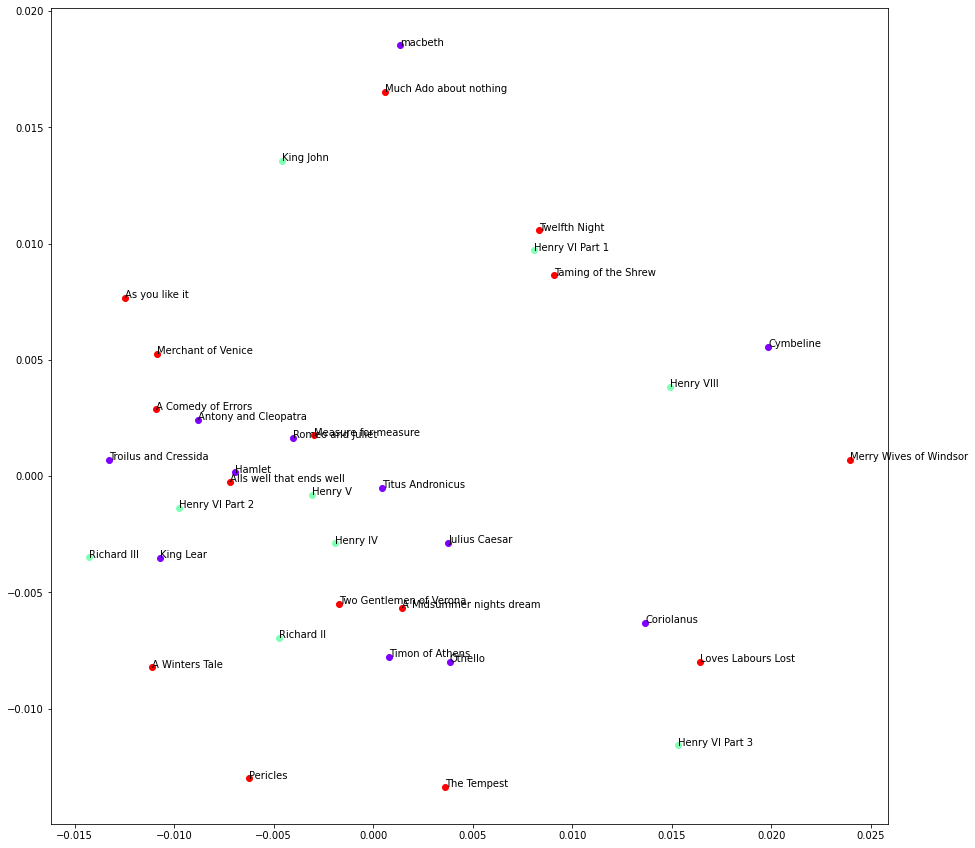

In [ ]:
play_trag_vect = np.array(play_trag_vect)
play_hist_vect = np.array(play_hist_vect)
play_com_vect = np.array(play_com_vect)
pca_2(play_trag_vect, play_hist_vect, play_com_vect, trag, hist, com)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


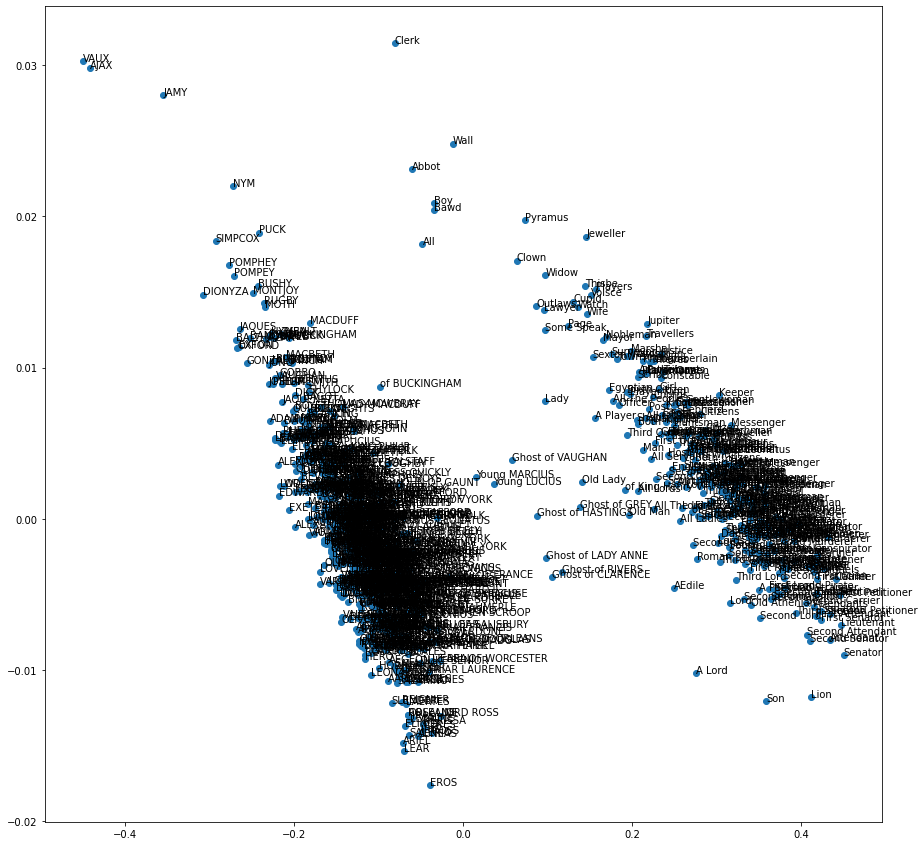

In [ ]:
## Question 8
df_char = df.groupby([4])[2].apply(lambda x : ' '.join(x))
chars_tokens = df_char.drop_duplicates().reindex(chars).reset_index().iloc[:,0]

features_extractor, _ = word_vec(chars_tokens, size=100, min_count=1)
chars_vect = w2vec_extract(features_extractor, chars_tokens) 
chars_vect = np.array(chars_vect) 
pca(chars_vect, chars)